# Project Description
* This is the Mini-project for course Introduction to Deep Learning Week 5 GANS
* The dataset used in this project is from Kaggle Monet Painting Dataset [https://www.kaggle.com/competitions/gan-getting-started](http://)
* The dataset contains painting images and photos in both jpg format and TFRecords format.
* The goal of this project is to build a GAN which consists of at least two neural networks(generator and discriminator) to generate images in the style of Monet.
* Citation @misc{gan-getting-started,
    author = {Amy Jang, Ana Sofia Uzsoy, Phil Culliton},
    title = {I’m Something of a Painter Myself},
    publisher = {Kaggle},
    year = {2020},
    url = {https://kaggle.com/competitions/gan-getting-started}
}
* In order to achive the goal of the project, I will build a CycleGAN model for translating painting to photos and photos to painting. The CycleGAN is a technique that involves the automatic training of image-to-image translation model without paired examples. Which fits our project as the dataset provided are not paired examples.


*   The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of two generator models and two discriminator models.

* Gitlink: https://github.com/DaisyWenwenHuang/Monet_CycleGan.git



Rreferences:

https://github.com/junyanz/CycleGAN/

https://github.com/keras-team/keras-contrib

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

**Process:**

**GAN1**   
*   Painting --> Generator1--> generated_photo1
*   generated_photo-->discriminator--> real/fake

**GAN2**
*   photo-->Generator2--> generated_painting1
*   generated_painting--> discriminator--> real/fake

**Forward cycle**  :


*   generated_photo1-->Generator2-->generated_painting_FW
*   loss calculates the difference betwwen painting and generated_painting_FW
*   update Generator2


**Forward cycle consistency loss**:

1.   Input paiting to GAN1
2.   Output photo(generated) from GAN1

1.   Input photo(generated) from GAN1 to GAN2
2.   Output painting(generated) from GAN2

1.   Compare painting(real) to painting from GAN2(generated)


**Backward cycle** :

*   generated_painting1-->Generator1-->generated_photo_BW
*   loss calculates the difference betwwen photo and generated_photo_BW
*   update Generator1

**Backward cycle consistency loss**:

1.   Input photo to GAN2
2.   Output painting(generated) from GAN2

1.   Input painting(generated) from GAN2 to GAN1
2.   Output photo(generated) from GAN1

1.   Compare painting(real) to painting from GAN1(generated)


In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dpnfodqx
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dpnfodqx
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=4f239edce240ded79d1592aa5a9bf2e56cbcc8446c96d4e794ff46d77b79fb1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1higa_dd/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR']="/content/gdrive/MyDrive/GAN"

%cd /content/gdrive/MyDrive/GAN


Mounted at /content/gdrive
/content/gdrive/MyDrive/GAN


In [4]:
pwd

'/content/gdrive/MyDrive/GAN'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

import tensorflow_datasets as tfds

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, LeakyReLU,Input,Activation,Concatenate,\
Conv2DTranspose
from tensorflow.keras.utils import plot_model,load_img
import PIL

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
np.random.seed(401)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
# load the dataset path and take a look at all the folders inside
IMG_DIR = '/content/gdrive/MyDrive/GAN'
# get a list of folder names of the working directory
print(os.listdir(IMG_DIR))

['monet_tfrec', 'monet_jpg', 'photo_jpg', 'photo_tfrec', 'discriminator_model_plot.png', 'generator_model_plot.png', 'composite_model_plot.png', 'cyclegan-monet.ipynb']


In [7]:
Monet_jpg = IMG_DIR+'/monet_jpg/'
Monet_tfrec = IMG_DIR+'/monet_tfrec/'
Photo_jpg = IMG_DIR+'/photo_jpg/'
Photo_tfrec = IMG_DIR+'/photo_tfrec/'

In [8]:
print(f'There are {len(os.listdir(Monet_jpg))} images in Monet_jpg folder.')
print(f'There are {len(os.listdir(Monet_tfrec))} TFRecord files in Monet_tfrec folder.')
print(f'There are {len(os.listdir(Photo_jpg))} images in Photo_jpg folder.')
print(f'There are {len(os.listdir(Photo_tfrec))} TFRecord files in Photo_tfrec folder.')

There are 300 images in Monet_jpg folder.
There are 5 TFRecord files in Monet_tfrec folder.
There are 7038 images in Photo_jpg folder.
There are 20 TFRecord files in Photo_tfrec folder.


(256, 256, 3)

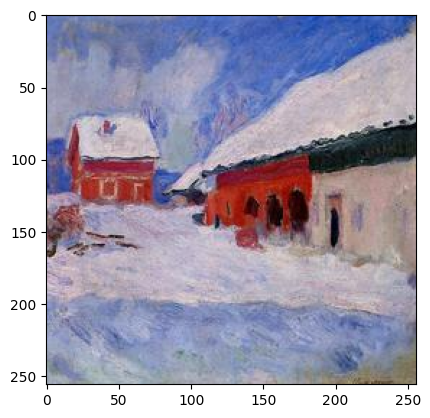

In [9]:
# sample painting
i = np.random.randint(0,300)
sample = Monet_jpg+os.listdir(Monet_jpg)[i]
sample_pt = imread(sample)
plt.imshow(sample_pt)
sample_pt.shape

(256, 256, 3)

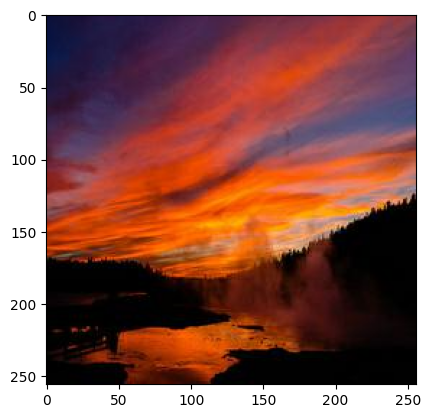

In [10]:
# sample photo
i = np.random.randint(0,7038)
sample = Photo_jpg+os.listdir(Photo_jpg)[i]
sample_ph = imread(sample)
plt.imshow(sample_ph)
sample_ph.shape

In [11]:
# check dimenson of all the Monet_jpg images
Dim1 = []
Dim2 = []
CS = []
for ele in os.listdir(Monet_jpg):
    img = imread(Monet_jpg+ele)
    D1,D2,C = img.shape
    Dim1.append(D1)
    Dim2.append(D2)
    CS.append(C)

D_Monet = pd.DataFrame({'D1': Dim1,'D2':Dim2,'C':CS})
D_Monet.describe()

,D1,D2,C
count,300.0,300.0,300.0
mean,256.0,256.0,3.0
std,0.0,0.0,0.0
min,256.0,256.0,3.0
25%,256.0,256.0,3.0
50%,256.0,256.0,3.0
75%,256.0,256.0,3.0
max,256.0,256.0,3.0


In [12]:
# check dimenson of all the Photo_jpg images
Dim1 = []
Dim2 = []
CS = []
for ele in os.listdir(Photo_jpg):
    img = imread(Photo_jpg+ele)
    D1,D2,C = img.shape
    Dim1.append(D1)
    Dim2.append(D2)
    CS.append(C)

D_Photo = pd.DataFrame({'D1': Dim1,'D2':Dim2,'C':CS})
D_Photo.describe()

,D1,D2,C
count,7038.0,7038.0,7038.0
mean,256.0,256.0,3.0
std,0.0,0.0,0.0
min,256.0,256.0,3.0
25%,256.0,256.0,3.0
50%,256.0,256.0,3.0
75%,256.0,256.0,3.0
max,256.0,256.0,3.0


In [13]:
img_size = (256,256)
img_channel = 3
img_shape = (256,256,3)


In [14]:
# function to load img and convert to array,scale
def load_images(path,size=(256,256)):
    data_list = list()
    _list=os.listdir(path)
    # print(_list)
    for file in _list:
        # print(file)
        # print(path+file)
        img = load_img(path+file)
        img = img_to_array(img)
        img = img/127.5-1
        data_list.append(img)
    return np.asarray(data_list)

In [15]:
# load Monet painting, conver to array and save to local file
Monet_arr = load_images(Monet_jpg)
print(Monet_arr.shape)


(300, 256, 256, 3)


In [16]:
# load photo, conver to array and save to local file
Photo_arr = load_images(Photo_jpg)
print(Photo_arr.shape)


(7038, 256, 256, 3)


**Discriminator**

Define discriminator using PatchGAN which is designed based on the size of the receptive field that is the relationship between one output activation of the model to an area on the input image. Let Ck denote a Convolution-BatchNrom-ReLU layer with k filters, all convolustions are (4,4) spatical filters with stride 2 application. The 70x70 discriminator architecture is C64-C128-C256-C512. BatchNorm is not applied to the first C64 layer.

In [17]:
def CBR_block(d_in,k,instance_norm=True):
    # initializa weight
    init = RandomNormal(stddev=0.02)
    d = Conv2D(k,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d_in)
    if instance_norm:
        d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    return d

In [18]:
def discriminator(img_shape): #(256,256,3):
    # initializa weight
    init = RandomNormal(stddev=0.02)
    # image input
    in_img = Input(shape=img_shape)

    #C64
    d = CBR_block(in_img,64,instance_norm=False)
    #C128
    d = CBR_block(d,128,instance_norm=True)
    #C256
    d = CBR_block(d,256,instance_norm=True)
    #C512
    d = CBR_block(d,512,instance_norm=True)
    # layer before output
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # output layer
    patch_out =Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
    # define model
    model = Model(in_img,patch_out)
    # compile model
    # mean squared error is used between the target values of class 1 (real) and class 0(fake)
    # The loss for the discriminator is weighted by 50% for each model update
    # to slow down the rate at which Discriminator learns relative to generator
    model.compile(loss='mse',optimizer=Adam(learning_rate=0.0002,beta_1=0.5),loss_weights=[0.5])
    return model

In [19]:
d_Monet = discriminator(img_shape)
d_Photo = discriminator(img_shape)
d_Monet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization (In  (None, 64, 64, 128)       256       
 stanceNormalization)                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

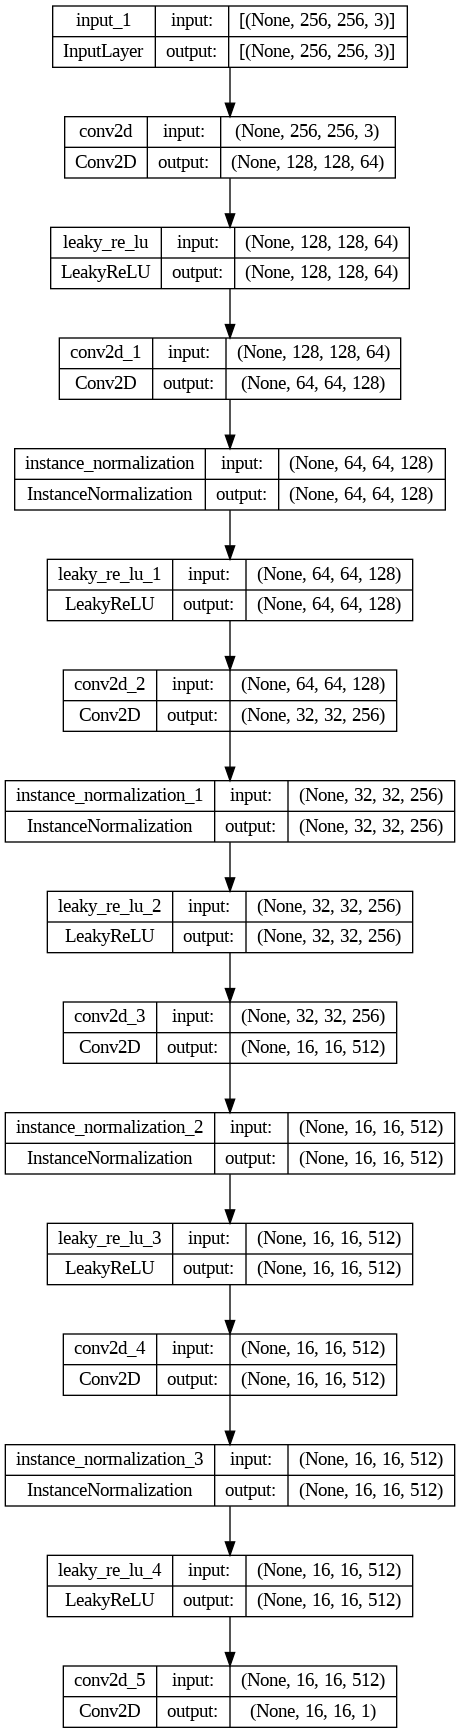

In [20]:
plot_model(d_Monet,to_file='discriminator_model_plot.png',show_shapes=True,show_layer_names=True)

**Generator**

Define CycleGAN Generator which takes an imput image and generates a translated image as ouput.The model uses a combination of downsampling convolutional blocks, upsampling convolutional blocks and resnet block in between.

The ResNet blcok are two 3x3 CNN layers where the input to the block is concatenated to the output of the block, channel-wise. For a 256x256 input image, 9-resnet blcok is needed.


In [21]:
def resnet_block(n_filters, input_layer):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    # convolutional layer
    g = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # convolutional layer
    g = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate channel-wise with input layer
    g = Concatenate()([g,input_layer])
    return g

In [22]:
def downsampling(in_put,k,size=(3,3),strides=(2,2)):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    g = Conv2D(k, size, strides=strides, padding='same', kernel_initializer=init)(in_put)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    return g

In [23]:
def upsampling(in_put,k,size=(3,3),strides=(2,2)):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(k, size, strides=strides, padding='same', kernel_initializer=init)(in_put)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    return g

In [24]:
def generator(img_shape=(256,256,3),n_resnet=9):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    # image in
    in_img = Input(shape=img_shape)
    # C7S1-64
    g = downsampling(in_img,64,size=(7,7),strides=(1,1))
    # D128
    g = downsampling(g,128)
    # D256
    g = downsampling(g,256)
    # R256
    for i in range(n_resnet):
        g = resnet_block(256,g)
    # U128
    g = upsampling(g,128)
    # U64
    g = upsampling(g,64)
    # C7S1-3
    g = Conv2DTranspose(3,(7,7),padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_img = Activation('tanh')(g)

    # define model
    model = Model(in_img,out_img)
    return model

In [25]:
g_MtoPH = generator(img_shape)
g_PHtoM = generator(img_shape)
g_MtoPH.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 instance_normalization_8 (  (None, 256, 256, 64)         128       ['conv2d_12[0][0]']           
 InstanceNormalization)                                                                           
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['instance_normalization

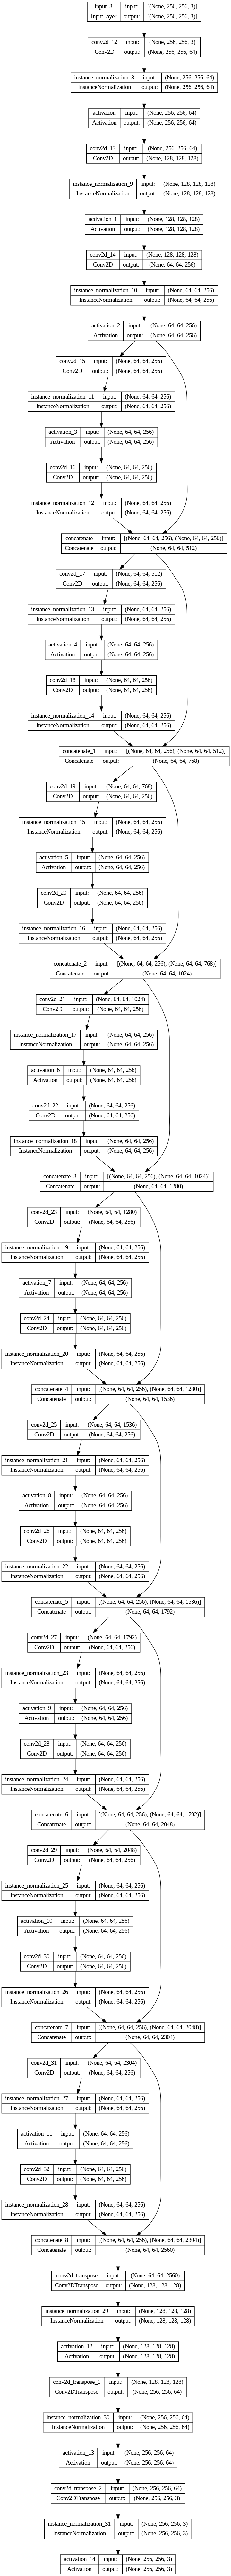

In [26]:
plot_model(g_MtoPH,to_file='generator_model_plot.png',show_shapes=True,show_layer_names=True)

**Composite model loss**

The gnerator models are updated via composite models, the model weights update depending on


1.   Adversarial loss (L2 or mean squared error)
2.   Identity loss (L1 or mean absolute error)

1.   Forward cycle loss (L1 or mean absolute error)
2.   Backward cycle loss (L1 or mean absolute error)

**Composite model**

The composite model takes two inputes: one real painting from Monet and one photo. The model outputs four outputs: one for the discriminator, one for the generator for the idenity mapping, one from the forward cycle, and one from the backward cycle.

In [27]:
def composite_model(g_1,d,g_2,img_shape):
    # make models need to be updated traninable
    g_1.trainable = True
    g_2.trainable = False
    d.trainable = False
    # discriminate process
    input_gen = Input(shape=img_shape)
    gen1_out =  g_1(input_gen)
    d_output = d(gen1_out)
    # identity process
    input_id = Input(shape = img_shape)
    output_id = g_1(input_id)
    # froward cycle
    output_f = g_2(gen1_out)
    # backward cycle
    gen2_out = g_2(input_id)
    output_b = g_1(gen2_out)
    # model graph
    model = Model([input_gen,input_id],[d_output,output_id,output_f,output_b])
    # optimization
    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    # compile
    # weighted loss parameter lambda
    # forward and backward cycle loss is 10 while adversarial loss is set to 1.
    model.compile(loss=['mse','mae','mae','mae'],loss_weights = [1,5,10,10],
                  optimizer=opt)
    return model

In [28]:
Monet_to_Photo = composite_model(g_MtoPH,d_Photo,g_PHtoM,img_shape)
Photo_to_Monet = composite_model(g_PHtoM,d_Monet,g_MtoPH,img_shape)

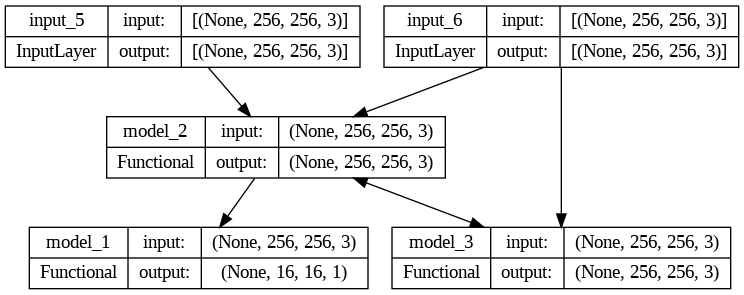

In [29]:
plot_model(Monet_to_Photo,to_file='composite_model_plot.png',show_shapes=True,show_layer_names=True)

Training model

In [30]:
# select a batch of random samples
def generate_real_samples(dataset,n_samples, patch_shape):
    # random choose
    ix = np.random.randint(0,dataset.shape[0],n_samples)
    # get selected img
    X = dataset[ix]
    # generate labels (1)
    y = np.ones((n_samples,patch_shape,patch_shape,1))
    return X,y

In [31]:
# test for error
patch_shape = 16
a,b=generate_real_samples(Monet_arr ,2, patch_shape)
a.shape,b.shape

((2, 256, 256, 3), (2, 16, 16, 1))

In [32]:
# generate a batch of fake images
def generate_fake_samples(g_model,dataset,patch_shape):
    # generate img
    X = g_model.predict(dataset)
    # genreate labels (0)
    y =  np.zeros((len(X),patch_shape,patch_shape,1))
    return X,y

In [33]:
# test for error
a_f,b_f = generate_fake_samples(g_MtoPH,a,patch_shape)
a_f.shape,b_f.shape

1/1 [==============================] - 14s 14s/step


((2, 256, 256, 3), (2, 16, 16, 1))

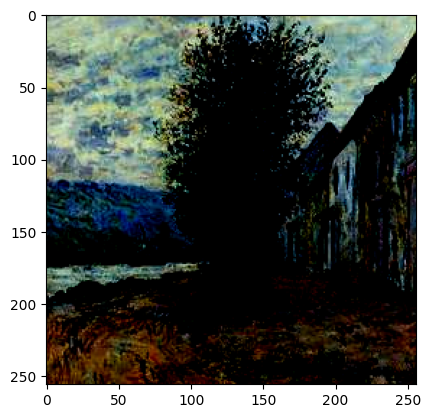

In [34]:
# show the real img
plt.imshow(a[0])

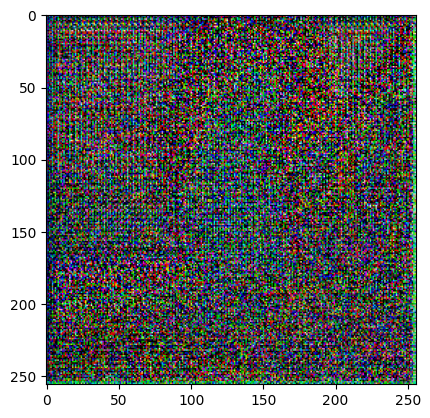

In [35]:
# show generated fake img
plt.imshow(a_f[0])

The genreated img is not looking good but that is ok. we have not train and update the generator yet.

In [36]:
# save generator models to local file
def save_models(step,g_MtoPH,g_PHtoM):
    name1 = 'g_MtoPH_%06d.h5'%(step+1)
    g_MtoPH.save(name1)

    name2 ='g_PHtoM_%06d.h5'%(step+1)
    g_PHtoM.save(name2)
    print(f"Done saving {step+1}")

In [37]:
# make a image pool for fake images, the maximum number in the pool is 100
# when reach the maximum number, a new fake image will randomly replace an old one
def fake_pool(pool,images,max_size=100):
    selected = list()
    for image in images:
        if len(pool)<max_size:
            # can still push fake image in
            pool.append(image)
            selected.append(image)
        elif np.random.random()<0.5:
            # use image, but do not add it to the pool
            selected.append(image)
        else:
            #replace an old one with a new one
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [38]:
def train_model(d_M,d_PH,g_MtoPH,g_PHtoM,c_MtoPH,c_PHtoM,trainM,trainPH):
    # training properties
    epochs = 2
    batch_n = 1
    #
    n_patch = d_M.output_shape[1]
    poolM,poolPH = list(),list()
    bat_per_epo = int(len(trainM)/batch_n)
    # number of training iterations
    n_steps = bat_per_epo*epochs
    # enumerate epochs
    for i in range(n_steps):
        # a batch of real samples
        X_realM,y_realM = generate_real_samples(trainM,batch_n,n_patch)
        X_realPH,y_realPH = generate_real_samples(trainPH,batch_n,n_patch)
        # generate a batch of fake samples
        X_fakeM,y_fakeM = generate_fake_samples(g_PHtoM,X_realM,n_patch)
        X_fakePH,y_fakePH = generate_fake_samples(g_MtoPH,X_realPH,n_patch)
        # update fake pool
        X_fakeM = fake_pool(poolM,X_fakeM,max_size=100)
        X_fakePH = fake_pool(poolPH,X_fakePH,max_size=100)
        # update generator g_PHtoM
        g_lossPHtoM,_,_,_,_=Photo_to_Monet.train_on_batch([X_realPH,X_realM],[y_realM,X_realM,X_realPH,X_realM])
        # update discriminator for d_M
        dM_loss1 = d_M.train_on_batch(X_realM,y_realM)
        dM_loss2 = d_M.train_on_batch(X_fakeM,y_fakeM)
        # update generator g_MtoPH
        g_lossMtoPH,_,_,_,_ = Monet_to_Photo.train_on_batch([X_realM,X_realPH],[y_realPH,X_realPH,X_realM,X_realPH])
        # update discriminator for d_PH
        dPH_loss1 = d_PH.train_on_batch(X_realPH,y_realPH)
        dPH_loss2 = d_PH.train_on_batch(X_fakePH,y_fakePH)
        # save model once in a while
        if (i+1) % 300 == 0:
            save_models(i,g_MtoPH,g_PHtoM)


In [39]:
Monet_arr.shape,Photo_arr.shape

((300, 256, 256, 3), (7038, 256, 256, 3))

In [40]:
# using a smaller set for testing
small_Monet = Monet_arr[:10]
small_Photo = Photo_arr[:10]

In [41]:
train_model(d_Monet,d_Photo,g_MtoPH,g_PHtoM,Monet_to_Photo,Photo_to_Monet,Monet_arr,Photo_arr)

1/1 [==============================] - 0s 21ms/step


Done saving 300
1/1 [==============================] - 0s 34ms/step


Done saving 600


1/1 [==============================] - 0s 22ms/step


(-0.5, 255.5, 255.5, -0.5)

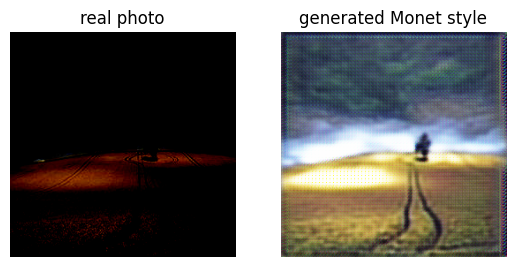

In [42]:
# test for error
# get a real photo
sam_img = generate_real_samples(Photo_arr,1,16)
# genereate Monet style of the photo
sam_gened=generate_fake_samples(g_PHtoM,sam_img[0],16)
# show imgs side by side
plt.subplot(121)
plt.title('real photo')
plt.imshow(sam_img[0][0])
plt.axis('off')

plt.subplot(122)
plt.title('generated Monet style')
# plt.imshow((sam_gened[0][0]+1)/2.0)
plt.imshow(sam_gened[0][0]*0.5+0.5)
plt.axis('off')


Model trained
The prediction part will be in a separate file